# Desafio 1 - Maratona Behind the Code 2021

## Bibliotecas

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from dotenv import find_dotenv, load_dotenv
from ibm_watson_machine_learning import APIClient
from IPython.display import display
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              RandomForestClassifier)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split  #, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier

## Configurações

In [2]:
seed: int = 0
data_path: Path = Path("../desafio/assets/data/")
set_config(display="diagram")

## Dados

### Junção dos datasets

In [3]:
accounts = pd.read_csv(data_path / "ACCOUNTS.csv", index_col="ID")
account_cols = list(accounts.columns)
print(account_cols)

['CHECKING_BALANCE', 'CREDIT_HISTORY', 'EXISTING_SAVINGS', 'EXISTING_CREDITS_COUNT']


In [4]:
demographics = pd.read_csv(data_path / "DEMOGRAPHICS.csv", index_col="ID")
demographic_cols = list(demographics.columns)
print(demographic_cols)

['SEX', 'AGE', 'JOB_TYPE', 'DEPENDENTS', 'TELEPHONE', 'FOREIGN_WORKER', 'EMPLOYMENT_DURATION', 'PROPERTY', 'HOUSING', 'CURRENT_RESIDENCE_DURATION']


In [5]:
loans = pd.read_csv(data_path / "LOANS.csv", index_col="ID")
loan_cols = list(loans.columns)
print(loan_cols)

['PAYMENT_TERM', 'INSTALLMENT_PLANS', 'INSTALLMENT_PERCENT', 'LOAN_PURPOSE', 'LOAN_AMOUNT', 'OTHERS_ON_LOAN', 'ALLOW']


In [6]:
answers = pd.read_csv(data_path / "ANSWERS.csv")
df_all = pd.concat([accounts, demographics, loans], axis=1).reset_index()[answers.columns]

### Informações gerais

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          3999 non-null   int64  
 1   CHECKING_BALANCE            2467 non-null   object 
 2   PAYMENT_TERM                3975 non-null   float64
 3   CREDIT_HISTORY              2462 non-null   object 
 4   LOAN_PURPOSE                3979 non-null   object 
 5   LOAN_AMOUNT                 3981 non-null   float64
 6   EXISTING_SAVINGS            2467 non-null   object 
 7   EMPLOYMENT_DURATION         3923 non-null   float64
 8   INSTALLMENT_PERCENT         3974 non-null   float64
 9   SEX                         3920 non-null   object 
 10  OTHERS_ON_LOAN              3977 non-null   object 
 11  CURRENT_RESIDENCE_DURATION  3917 non-null   float64
 12  PROPERTY                    3918 non-null   object 
 13  AGE                         3918 

- A maioria das variáveis (colunas) são numéricas, mas há algumas categóricas.
- Com exceção da variável que identifica cada cliente (`ID`) e da variável de destino (`ALLOW`), todas têm dados faltantes (nulos).

### Divisão dos dados entre treino e teste

Antes de inspecionar os dados, serão reservados alguns exemplos para teste, que não serão vistos durante a análise ou modelagem dos dados:

In [8]:
test_size = 500
target = "ALLOW"
df_train, df_test = train_test_split(df_all, test_size=test_size, random_state=seed, stratify=df_all[[target]])
print(f'Dimensões dos dados de treino: {df_train.shape}')
print(f'Dimensões dos dados de teste: {df_test.shape}')

Dimensões dos dados de treino: (3499, 22)
Dimensões dos dados de teste: (500, 22)


### Variável destino

A variável destino para este desafio é a `ALLOW`, significando se um empréstimo deverá ser permitido ou não, baseado nas informações dadas. Vamos dar uma olhada em como está a distribuição dessa variável

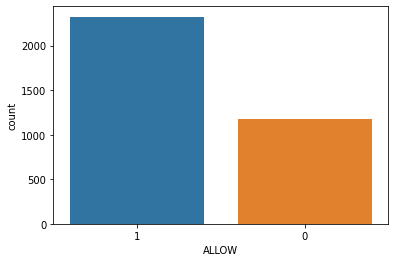

In [9]:
risk_plot = sns.countplot(
    data=df_train, x=target, order=df_train[target].value_counts().index
)
plt.show()

### Dados de exemplo

In [10]:
with pd.option_context("display.max_columns", None):
    display(df_train.sample(10, random_state=seed))

,ID,CHECKING_BALANCE,PAYMENT_TERM,CREDIT_HISTORY,LOAN_PURPOSE,LOAN_AMOUNT,EXISTING_SAVINGS,EMPLOYMENT_DURATION,INSTALLMENT_PERCENT,SEX,OTHERS_ON_LOAN,CURRENT_RESIDENCE_DURATION,PROPERTY,AGE,INSTALLMENT_PLANS,HOUSING,EXISTING_CREDITS_COUNT,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,ALLOW
1300,443445,NaN,270.0,NaN,CAR_NEW,250.0,NaN,0.0,1.0,M,NONE,2.0,REAL_ESTATE,24.0,NONE,RENT,NaN,3.0,1.0,0.0,1.0,1
3697,1208610,NaN,1170.0,NaN,APPLIANCES,4545.0,NaN,6.0,3.0,M,NONE,3.0,UNKNOWN,35.0,NONE,OWN,NaN,3.0,2.0,1.0,1.0,0
2710,887509,NO_CHECKING,630.0,CREDITS_PAID_TO_DATE,FURNITURE,1903.0,980.41,7.0,4.0,M,NONE,4.0,SAVINGS_INSURANCE,53.0,NONE,OWN,1.0,3.0,1.0,1.0,1.0,1
3914,1291443,144.51,465.0,PRIOR_PAYMENTS_DELAYED,FURNITURE,1931.0,53.87,4.0,3.0,M,NONE,4.0,CAR_OTHER,35.0,STORES,OWN,2.0,1.0,1.0,0.0,1.0,1
200,76618,NO_CHECKING,510.0,CREDITS_PAID_TO_DATE,CAR_NEW,2720.0,201.44,4.0,3.0,M,NONE,4.0,SAVINGS_INSURANCE,34.0,NONE,RENT,1.0,2.0,1.0,0.0,1.0,1
3696,1206978,NO_CHECKING,960.0,OUTSTANDING_CREDIT,OTHER,9727.0,829.3,7.0,4.0,M,GUARANTOR,5.0,CAR_OTHER,57.0,NONE,FREE,2.0,3.0,2.0,1.0,1.0,0
3825,1261640,NO_CHECKING,806.0,OUTSTANDING_CREDIT,RADIO_TV,3782.0,997.69,6.0,4.0,F,NONE,3.0,UNKNOWN,45.0,NONE,OWN,1.0,3.0,2.0,1.0,1.0,0
675,229882,NaN,744.0,NaN,CAR_NEW,501.0,NaN,7.0,3.0,F,NONE,1.0,SAVINGS_INSURANCE,26.0,STORES,OWN,NaN,1.0,2.0,1.0,1.0,1
1976,658037,NO_CHECKING,720.0,PRIOR_PAYMENTS_DELAYED,EDUCATION,1828.0,UNKNOWN,3.0,3.0,M,NONE,3.0,SAVINGS_INSURANCE,44.0,NONE,OWN,1.0,3.0,1.0,0.0,1.0,0
3674,1198137,NO_CHECKING,713.0,PRIOR_PAYMENTS_DELAYED,RADIO_TV,3252.0,133.37,8.0,4.0,F,NONE,4.0,CAR_OTHER,51.0,NONE,OWN,2.0,3.0,1.0,0.0,1.0,0


### Variáveis categóricas

In [11]:
non_numeric_cols = list(df_train.select_dtypes(exclude='number').columns)

In [12]:
with pd.option_context("display.max_columns", None):
    display(df_train.describe(include="O"))

,CHECKING_BALANCE,CREDIT_HISTORY,LOAN_PURPOSE,EXISTING_SAVINGS,SEX,OTHERS_ON_LOAN,PROPERTY,INSTALLMENT_PLANS,HOUSING
count,2155,2151,3481,2155,3433,3480,3432,3480,3428
unique,1233,5,11,1965,2,3,4,3,3
top,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,CAR_NEW,UNKNOWN,M,NONE,SAVINGS_INSURANCE,NONE,OWN
freq,859,735,649,149,2122,2893,1135,2428,2209


A quantidade de valores únicos para as variáveis `CHECKING_BALANCE` e `EXISTING_SAVINGS` é relativamente grande (>30%), e observando-se os dados de exemplo, há indícios de que boa parte dos valores possam ser numéricos:

In [13]:
max_unique_treshold = 0.3
cols_with_many_unique_values = df_train[non_numeric_cols].nunique() > max_unique_treshold * len(df_train)
possibly_numeric_cols = list(df_train[non_numeric_cols].columns[cols_with_many_unique_values])
possibly_numeric_cols

['CHECKING_BALANCE', 'EXISTING_SAVINGS']

In [14]:
for col in possibly_numeric_cols:
    display(
        df_train[col]
        .value_counts()
        .reset_index()
        .sort_values([col, "index"], ascending=False)
        .rename(columns={col: "Quantidade", "index": "Valor"})
        .set_index("Valor")
        .head(3)
    )

,Quantidade
Valor,
NO_CHECKING,859
0,57
97.41,3


,Quantidade
Valor,
UNKNOWN,149
28.92,3
100.89,3


Na hora da modelagem, teremos algumas opções do que fazer com estas colunas:
- Tratar essas colunas como variáveis numéricas, deixando que valores textuais como `NO_CHECKING` e `UNKNOWN` sejam substituídos por `NaN` (e posteriormente imputar um valor, por exemplo, zero).
- Se for relevante distinguir o caso anterior dos zeros que já estavam nestas colunas, poderia ser criada uma nova variável binária cujo valor fosse `True` quando a variável original fosse não numérica, e `False` nos demais casos

### Remoção de texto em variáveis numéricas

Por hora, apenas para visualizar estatísticas sobre os valores numéricos, valores textuais nessas colunas serão trocados por `NaN` usando um *transformer* personalizado:

#### Instalação de um pacote extra

In [15]:
!rm -rf custom_sklearn_transformers
!git clone git@github.com:he7d3r/custom_sklearn_transformers.git
!git --git-dir custom_sklearn_transformers/.git archive -o custom_sklearn_transformers.zip HEAD
!pip install --quiet --upgrade pip custom_sklearn_transformers.zip

Cloning into 'custom_sklearn_transformers'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 0), reused 12 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), done.


#### Uso do pacote

In [16]:
from custom_sklearn_transformers.transformers import ToNumeric

In [17]:
to_numeric = ToNumeric(possibly_numeric_cols, errors='coerce')

Para criar um modelo capaz de fazer transformações nos dados de entrada, vamos criar uma `Pipeline` do `scikit-learn` e aplicar nossas transformações de pré-processamento dentro dos estágios dela.

In [18]:
preprocessor = Pipeline([
    ('to_numeric', to_numeric),
])
clean_df = preprocessor.fit_transform(df_train)

Estes são os valores que as outras variáveis não numéricas assumem:

In [19]:
sorted_cat_cols = list(sorted(set(non_numeric_cols) - set(possibly_numeric_cols)))
for col in sorted_cat_cols:
    display(clean_df[col].value_counts().to_frame().T)

,PRIOR_PAYMENTS_DELAYED,CREDITS_PAID_TO_DATE,OUTSTANDING_CREDIT,ALL_CREDITS_PAID_BACK,NO_CREDITS
CREDIT_HISTORY,735,633,394,336,53


,OWN,RENT,FREE
HOUSING,2209,720,499


,NONE,STORES,BANK
INSTALLMENT_PLANS,2428,710,342


,CAR_NEW,FURNITURE,CAR_USED,RADIO_TV,APPLIANCES,REPAIRS,VACATION,EDUCATION,RETRAINING,BUSINESS,OTHER
LOAN_PURPOSE,649,609,584,528,370,194,143,114,113,102,75


,NONE,CO-APPLICANT,GUARANTOR
OTHERS_ON_LOAN,2893,502,85


,SAVINGS_INSURANCE,CAR_OTHER,REAL_ESTATE,UNKNOWN
PROPERTY,1135,1056,748,493


,M,F
SEX,2122,1311


- Todas as variáveis poderiam ser convertidas em valores numéricos usando "One-Hot-Encoding".
- Alternativamente, algumas variáveis poderiam poderia ser convertidas para valores crescentes em uma ordem que aparenta ir da pior para a melhor situação (mas esta é uma avaliação subjetiva):
  - **`CREDIT_HISTORY`**: `PRIOR_PAYMENTS_DELAYED`, `NO_CREDITS`, `CREDITS_PAID_TO_DATE`, `ALL_CREDITS_PAID_BACK`, `OUTSTANDING_CREDIT`
  - **`OTHERS_ON_LOAN`**: `NONE`, `CO-APPLICANT`, `GUARANTOR`
  - **`HOUSING`**: `FREE`, `RENT`, `OWN`

### Variáveis numéricas

In [20]:
with pd.option_context("display.max_columns", None):
    display(clean_df.describe(exclude="O"))

,ID,CHECKING_BALANCE,PAYMENT_TERM,LOAN_AMOUNT,EXISTING_SAVINGS,EMPLOYMENT_DURATION,INSTALLMENT_PERCENT,CURRENT_RESIDENCE_DURATION,AGE,EXISTING_CREDITS_COUNT,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,ALLOW
count,3.499000e+03,1296.000000,3478.000000,3486.000000,2006.000000,3437.000000,3479.000000,3430.000000,3431.000000,2155.000000,3427.000000,3429.000000,3427.000000,3423.000000,3499.00000
mean,6.564330e+05,500.561914,652.430995,3471.581469,1366.428509,4.250509,2.979304,2.856851,36.105800,1.465429,2.425445,1.161855,0.414357,0.976337,0.66419
std,3.729361e+05,2742.738362,338.976026,2482.036344,4827.286202,3.586829,1.116362,1.110505,10.572843,0.569324,0.934158,0.368371,0.492682,0.152021,0.47234
min,9.800000e+01,-2617.350000,120.000000,250.000000,0.020000,0.000000,1.000000,1.000000,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000
25%,3.362930e+05,-186.057500,390.000000,1328.250000,64.845000,1.000000,2.000000,2.000000,28.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.00000
50%,6.586480e+05,0.000000,651.000000,3237.000000,253.825000,4.000000,3.000000,3.000000,36.000000,1.000000,3.000000,1.000000,0.000000,1.000000,1.00000
75%,9.710270e+05,109.872500,899.000000,5308.000000,726.065000,7.000000,4.000000,4.000000,44.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.00000
max,1.320082e+06,20104.120000,1984.000000,11676.000000,50177.310000,18.000000,6.000000,5.000000,74.000000,3.000000,3.000000,2.000000,1.000000,1.000000,1.00000


Sinta-se livre para ver a distribuição de outras colunas do conjunto de dados, utilizar os outros conjuntos de dados, explorar as correlações entre variáveis e outros.

In [21]:
numeric_cols = list(clean_df.select_dtypes(include='number').columns)

In [22]:
for col in numeric_cols:
    display(clean_df[col].value_counts().to_frame().T)

,458752,62880,1240455,824019,237742,1301901,451982,290191,749757,107930,...,731864,416220,606945,1102563,514790,1026792,1299179,27372,269870,901116
ID,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


,0.00,42.83,97.41,19.00,-170.13,158.35,94.06,-56.17,169.20,8771.09,...,-1128.33,87.85,-77.15,-93.04,-298.62,125.76,-5.96,88.92,-546.14,-842.31
CHECKING_BALANCE,57,3,3,2,2,2,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1


,124.0,120.0,930.0,240.0,744.0,775.0,600.0,868.0,810.0,620.0,...,1680.0,1860.0,1891.0,1984.0,1560.0,1710.0,1890.0,1829.0,1590.0,1830.0
PAYMENT_TERM,155,152,95,70,67,67,63,62,62,61,...,1,1,1,1,1,1,1,1,1,1


,250.0,1993.0,6954.0,4545.0,1820.0,3810.0,5011.0,3315.0,4842.0,3147.0,...,2463.0,6603.0,6591.0,6434.0,4674.0,6585.0,2956.0,368.0,3724.0,3896.0
LOAN_AMOUNT,505,5,4,4,4,4,3,3,3,3,...,1,1,1,1,1,1,1,1,1,1


,100.89,28.92,79.41,57.25,65.64,77.85,79.34,44.88,8.12,428.75,...,249.10,95.80,247.97,909.17,76.13,504.65,98.55,1063.49,484.31,55.06
EXISTING_SAVINGS,3,3,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


,0.0,7.0,5.0,6.0,1.0,3.0,2.0,4.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,18.0
EMPLOYMENT_DURATION,810,338,333,304,274,257,241,238,173,156,132,76,67,20,8,7,2,1


,3.0,2.0,4.0,1.0,5.0,6.0
INSTALLMENT_PERCENT,1130,854,851,342,291,11


,3.0,2.0,4.0,1.0,5.0
CURRENT_RESIDENCE_DURATION,1138,876,747,425,244


,19.0,40.0,36.0,37.0,34.0,31.0,38.0,39.0,41.0,33.0,...,61.0,65.0,66.0,63.0,62.0,74.0,70.0,64.0,73.0,67.0
AGE,278,129,127,121,118,116,116,110,110,109,...,7,5,3,3,2,2,1,1,1,1


,1.0,2.0,3.0
EXISTING_CREDITS_COUNT,1233,841,81


,3.0,1.0,2.0,0.0
JOB_TYPE,2331,467,426,203


,1.0,2.0
DEPENDENTS,2874,555


,0.0,1.0
TELEPHONE,2007,1420


,1.0,0.0
FOREIGN_WORKER,3342,81


,1,0
ALLOW,2324,1175


### Correlações

#### Variáveis sobre as contas

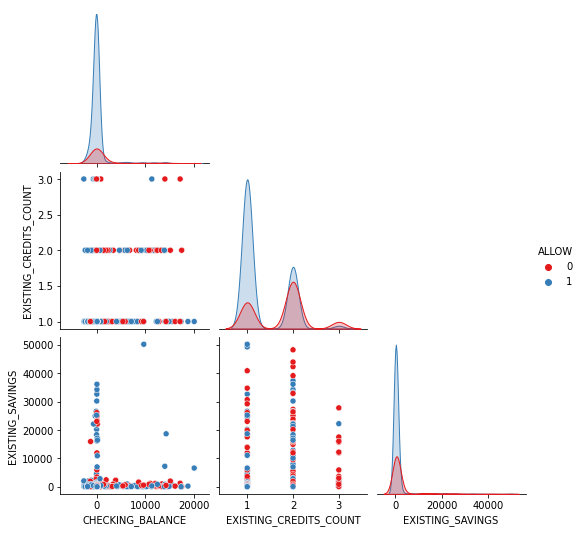

In [23]:
sorted_account_cols = list(sorted(set(account_cols + [target])))
sns.pairplot(clean_df[sorted_account_cols], hue=target, palette='Set1', corner=True)
plt.show()

#### Variáveis sobre dados demográficos

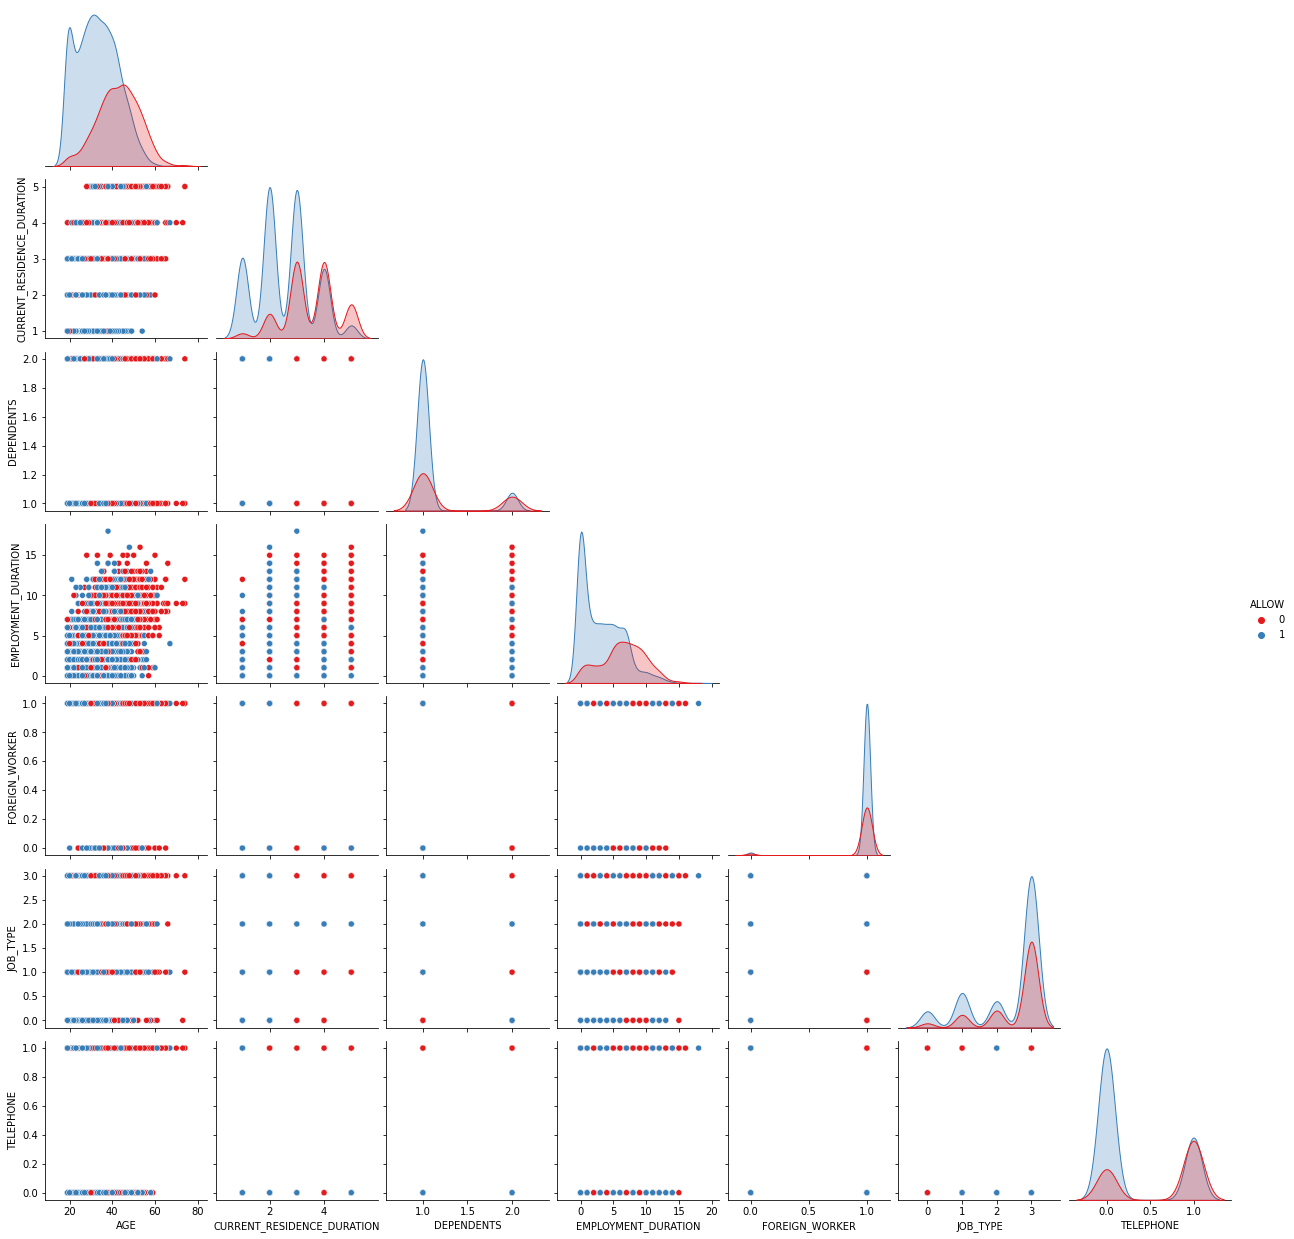

In [24]:
sorted_demographic_cols = list(sorted(set(demographic_cols + [target])))
sns.pairplot(clean_df[sorted_demographic_cols], hue=target, palette='Set1', corner=True)
plt.show()

- Talvez seja melhor considerar que o tipo de trabalho (`JOB_TYPE`) é uma variável categórica e fazer One-Hot-Encoding, assumindo que não exista necessariamente uma ordenação natural dos tipos

#### Variáveis sobre os empéstimos

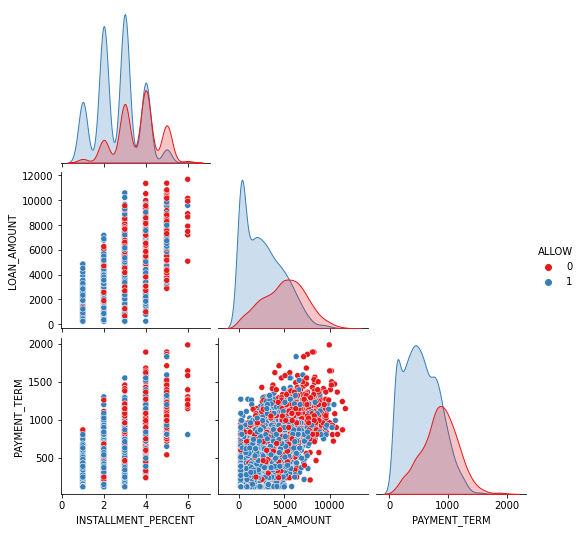

In [25]:
sorted_loan_cols = list(sorted(set(loan_cols + [target])))
sns.pairplot(clean_df[sorted_loan_cols], hue=target, palette='Set1', corner=True)
plt.show()

### Variáveis categóricas (gráficos)

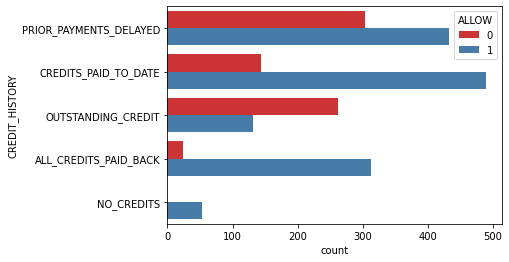

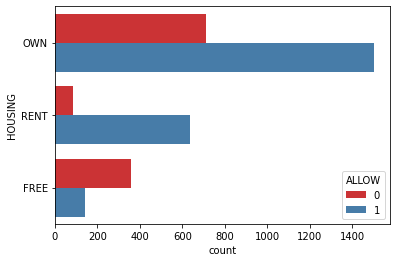

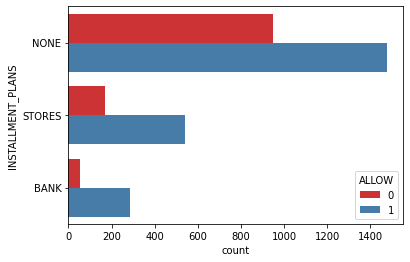

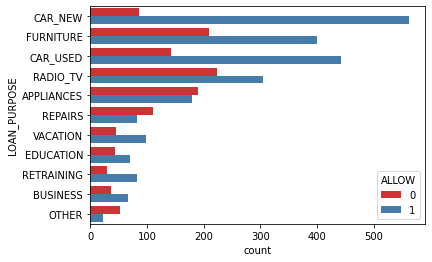

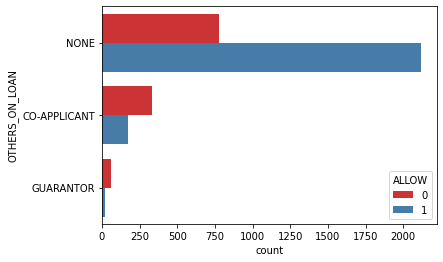

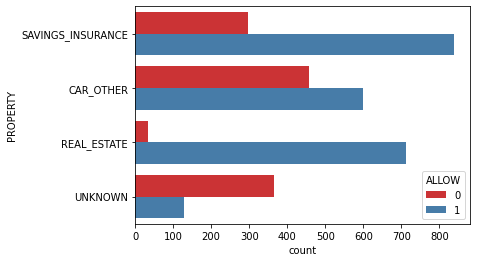

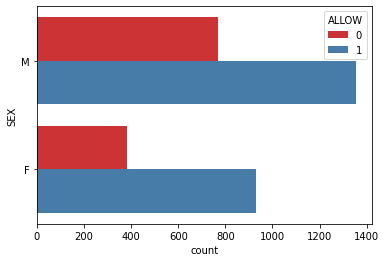

In [26]:
for col in sorted_cat_cols:
    risk_plot = sns.countplot(
        data=df_train, y=col, order=df_train[col].value_counts().index, orient='h', hue='ALLOW', palette='Set1'
    )
    plt.show()

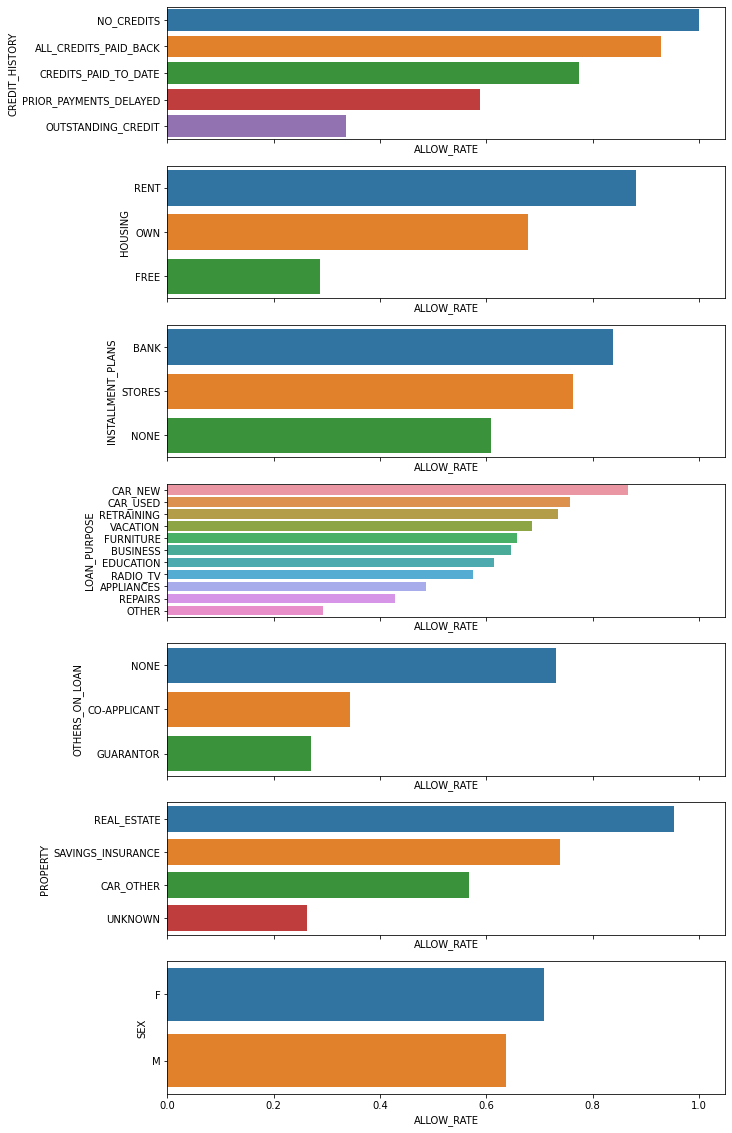

In [27]:
fig, axes = plt.subplots(nrows=len(sorted_cat_cols), sharex=True, figsize=(10,20))
for i, col in enumerate(sorted_cat_cols):
    group_means = df_train.groupby([col])['ALLOW'].mean().rename('ALLOW_RATE').sort_values(ascending=False).to_frame()
    sns.barplot(x='ALLOW_RATE', y=group_means.index, data=group_means, ax=axes[i])

## Tratamento dos dados

Uma vez que exploramos os dados, entendemos a importância de cada coluna e podemos fazer alterações nelas para para obter um melhor resultado.

#### Dados de entrada

O desafio espera um modelo que aceite todas as variáveis dos conjuntos de dados disponíveis (exceto a variável destino, `ALLOW`):

In [28]:
challenge_columns = [
    "ID",
    "CHECKING_BALANCE",
    "PAYMENT_TERM",
    "CREDIT_HISTORY",
    "LOAN_PURPOSE",
    "LOAN_AMOUNT",
    "EXISTING_SAVINGS",
    "EMPLOYMENT_DURATION",
    "INSTALLMENT_PERCENT",
    "SEX",
    "OTHERS_ON_LOAN",
    "CURRENT_RESIDENCE_DURATION",
    "PROPERTY",
    "AGE",
    "INSTALLMENT_PLANS",
    "HOUSING",
    "EXISTING_CREDITS_COUNT",
    "JOB_TYPE",
    "DEPENDENTS",
    "TELEPHONE",
    "FOREIGN_WORKER",
]

#### Dados categóricos

Observando a execução do método `.info()` acima, podemos ver que existem colunas do tipo `object`. O modelo do `scikit-learn` que vamos usar não é capaz de processar uma variável desse tipo. Portanto, para dar seguimento ao experimento, será utilizada a técnica de _one-hot encoding_ para tratamento de variáveis categóricas. Além disso, a coluna `ID` será desconsiderada, pois sabemos que ela não é uma informação útil para a predição (é apenas um número identificando um cliente).

Primeiramente, especificaremos quais variáveis serão tratadas como categóricas e quais serão tratadas como numéricas:

In [29]:
categorical_features = [
    "CREDIT_HISTORY",
    "LOAN_PURPOSE",
    "SEX",
    "OTHERS_ON_LOAN",
    "PROPERTY",
    "INSTALLMENT_PLANS",
    "HOUSING",
    "TELEPHONE",  # Boolean  # TODO: Impute some value instead OneHotEncoding the missing values
    "FOREIGN_WORKER",  # Boolean  # TODO: Impute some value instead OneHotEncoding the missing values
]
numeric_features = [
    "CHECKING_BALANCE",
    "PAYMENT_TERM",
    "LOAN_AMOUNT",
    "EXISTING_SAVINGS",
    "EMPLOYMENT_DURATION",
    "INSTALLMENT_PERCENT",
    "CURRENT_RESIDENCE_DURATION",
    "AGE",
    "EXISTING_CREDITS_COUNT",
    "JOB_TYPE", # NOTE: This could also be considered categorical
    "DEPENDENTS",
]

Qualquer outra variável será desconsiderada:

In [30]:
features = numeric_features + categorical_features
unwanted_columns = list(
    sorted((set(challenge_columns) - set([target])) - set(features))
)
print(unwanted_columns)

['ID']


A pipeline de pré-processamento será atualizada para que realize transformações específicas para cada tipo de variável:

In [31]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numeric_transformer = Pipeline(steps=[
    ('to_numeric', to_numeric),
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)
# display(preprocessor)

Nesta nova versão:
- As variáveis `CHECKING_BALANCE` e `EXISTING_SAVINGS` continuarão sendo convertidas para tipos numéricos
- One-Hot-Encoding será aplicado às variáveis categóricas, resultando em uma coluna para cada valor

A título de exemplo, a antiga coluna `SEX` foi transformada em novas colunas, uma para cada valor:

In [32]:
preprocessor.fit(df_train)
# onehot_features = list(preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out())
onehot_features = list(preprocessor.named_transformers_["cat"]["onehot"].get_feature_names())  # scikit-learn=0.23
clean_df = pd.DataFrame(
    preprocessor.transform(df_train),
    columns=numeric_features + onehot_features,
    index=df_train.index
)
# clean_df.head(4)
clean_df[clean_df.columns[clean_df.columns.str.endswith('_F') | clean_df.columns.str.endswith('_M')]].head(4)

,x2_F,x2_M
1866,0.0,1.0
2416,1.0,0.0
639,1.0,0.0
281,0.0,1.0


Esta é a lista completa das colunas criadas pelo One-Hot-Encoding:

In [33]:
print(onehot_features)

['x0_ALL_CREDITS_PAID_BACK', 'x0_CREDITS_PAID_TO_DATE', 'x0_NO_CREDITS', 'x0_OUTSTANDING_CREDIT', 'x0_PRIOR_PAYMENTS_DELAYED', 'x1_APPLIANCES', 'x1_BUSINESS', 'x1_CAR_NEW', 'x1_CAR_USED', 'x1_EDUCATION', 'x1_FURNITURE', 'x1_OTHER', 'x1_RADIO_TV', 'x1_REPAIRS', 'x1_RETRAINING', 'x1_VACATION', 'x2_F', 'x2_M', 'x3_CO-APPLICANT', 'x3_GUARANTOR', 'x3_NONE', 'x4_CAR_OTHER', 'x4_REAL_ESTATE', 'x4_SAVINGS_INSURANCE', 'x4_UNKNOWN', 'x5_BANK', 'x5_NONE', 'x5_STORES', 'x6_FREE', 'x6_OWN', 'x6_RENT', 'x7_0.0', 'x7_1.0', 'x8_0.0', 'x8_1.0']


#### Dados faltantes

Com as etapas de pré-processamento definidas até aqui, algumas colunas ainda têm valores faltantes:

In [34]:
clean_df[clean_df.columns[clean_df.isnull().sum() > 0]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3499 entries, 1866 to 415
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CHECKING_BALANCE            1296 non-null   float64
 1   PAYMENT_TERM                3478 non-null   float64
 2   LOAN_AMOUNT                 3486 non-null   float64
 3   EXISTING_SAVINGS            2006 non-null   float64
 4   EMPLOYMENT_DURATION         3437 non-null   float64
 5   INSTALLMENT_PERCENT         3479 non-null   float64
 6   CURRENT_RESIDENCE_DURATION  3430 non-null   float64
 7   AGE                         3431 non-null   float64
 8   EXISTING_CREDITS_COUNT      2155 non-null   float64
 9   JOB_TYPE                    3427 non-null   float64
 10  DEPENDENTS                  3429 non-null   float64
dtypes: float64(11)
memory usage: 457.1 KB


Nestes casos, faremos apenas um tratamento simples, de imputar o valor zero nas linhas que tiverem faltando algum valor. Não necessariamente essa técnica é a melhor para se utilizar no desafio, é apenas um exemplo de como tratar o dataset.

Tratamentos mais avançados, como modificação de colunas ou criação de novas colunas, serão incluídos na `Pipeline` posteriormente, se necessário.

In [35]:
imputer = SimpleImputer(strategy='constant', fill_value=0)

numeric_transformer = Pipeline(steps=[
    ('to_numeric', to_numeric),
    ('imputer', imputer),
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)
# display(preprocessor)

In [36]:
preprocessor.fit(df_train)
clean_df = pd.DataFrame(
    preprocessor.transform(df_train),
    columns=numeric_features + onehot_features,
    index=df_train.index
)
# display(clean_df.head(2))
# clean_df.info()

A nova pipeline de pré-processamento zera o número de colunas com dados faltantes:

In [37]:
clean_df.isnull().sum().sum()

0

## Criação do modelo

Com os dados prontos, podemos selecionar um modelo de Machine Learning para treinar com nossos dados. Nesse exemplo, vamos utilizar um modelo de classificação básico, o de Árvore de Decisão.

In [38]:
classifier = DecisionTreeClassifier(random_state=seed)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', classifier)
])

Pronto! Essa pipeline agora está pronta para receber todas as variáveis do desafio, transformá-las e passar para o modelo aquelas que forem relevantes:

In [39]:
# display(pipe)

Abaixo, separamos os dados que queremos predizer dos dados que utilizamos como informações para a predição.

In [40]:
X_train = df_train[challenge_columns]
y_train = df_train[target]
X_test = df_test[challenge_columns]
y_test = df_test[target]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3499, 21)
(3499,)
(500, 21)
(500,)


In [41]:
params = [
    {
    'clf':[SVC(random_state=seed)],
    'clf__C': [0.3],
    'clf__gamma': [0.2]
    },
    {
    'clf':[LinearSVC(random_state=seed)],
    'clf__C': [0.007],
    'clf__penalty': ['l2']
    },
    {
    'clf': [MLPClassifier(random_state=seed)],
    'clf__alpha': [0.25],
    'clf__hidden_layer_sizes': [225],
    'clf__learning_rate_init': [0.0002]
    },
    {
    'clf': [LogisticRegression(random_state=seed)],
    'clf__C': [5],
    'clf__penalty': ['l2']
    },
    {
    'clf': [GaussianNB()],
    },
    {
    'clf': [KNeighborsClassifier()],
    'clf__n_neighbors': [65],
    'clf__weights': ['uniform'],
    },
    {
    'clf': [DecisionTreeClassifier(random_state=seed)],
    'clf__max_depth': [7],
    'clf__max_features': [0.8],
    'clf__min_samples_split': [11],
    'clf__min_samples_leaf': [2],
    'clf__criterion': ['gini'],
    },
    {
    'clf': [AdaBoostClassifier(n_estimators=10, random_state=seed)],
    'clf__n_estimators': [81],
    'clf__learning_rate': [0.4],
    },
    {
    'clf': [ExtraTreesClassifier(n_estimators=10, random_state=seed)],
    'clf__n_estimators': [93],
    },
    {
    'clf': [RandomForestClassifier(n_estimators=10, random_state=seed)],
    'clf__max_depth': [30],
    'clf__n_estimators': [99],
    'clf__max_features': [0.35],
    'clf__min_samples_split': [32],
    'clf__min_samples_leaf': [4],
    'clf__criterion': ['gini']
    },
    {
    'clf': [BaggingClassifier(n_estimators=5, random_state=seed)],
    'clf__base_estimator': [SVC(C=0.3, gamma=0.2, random_state=seed)],
    'clf__n_estimators': [10],
    'clf__max_samples': [0.7],
    'clf__max_features': [0.7]
    },
    {
    'clf': [StackingClassifier(estimators=[
        ('svc', SVC(C=0.3, gamma=0.2, random_state=seed)),
        ('lsvc', LinearSVC(C=0.007, penalty='l2', random_state=seed)),
        ('mlpc', MLPClassifier(alpha=0.25, hidden_layer_sizes=225, learning_rate_init=0.0002, random_state=seed)),
        ('lr', LogisticRegression(C=5, penalty='l2', random_state=seed)),
        ('gnb', GaussianNB()),
        ('knn', KNeighborsClassifier(n_neighbors=65, weights='uniform')),
        ('dtc', DecisionTreeClassifier(max_depth=7, max_features=0.8, min_samples_split=11, min_samples_leaf=2, criterion='gini', random_state=seed)),
        ('abc', AdaBoostClassifier(n_estimators=81, learning_rate=0.4, random_state=seed)),
        ('etc', ExtraTreesClassifier(n_estimators=93, random_state=seed)),
        ('rfc', RandomForestClassifier(n_estimators=99, max_depth=30, max_features=0.35, min_samples_split=32, min_samples_leaf=4, criterion='gini', random_state=seed))
    ])],
    'clf__final_estimator': [SVC()]
    },
]

In [42]:
cv_num = 2
verbose = 5
scoring_metric='f1'
# cv = RandomizedSearchCV(pipe, param_distributions=params, n_jobs=-1, verbose=verbose, random_state=seed,
#                           cv=cv_num, n_iter=15, scoring=scoring_metric)
cv = GridSearchCV(pipe, params, cv=cv_num, n_jobs=-1, verbose=verbose, scoring=scoring_metric)
cv.fit(X_train, y_train)
model = cv.best_estimator_

print('Best train score: ', cv.best_score_)
print('Test score: ', cv.score(X_test, y_test))
print('Best estimator: ', cv.best_estimator_)
display('Best parameters: ', cv.best_params_)
display(pd.DataFrame(cv.cv_results_).sort_values('rank_test_score').head(20))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    2.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    2.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    4.1s finished


Best train score:  0.8506712494571795
Test score:  0.855539971949509
Best estimator:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('to_numeric',
                                                                   ToNumeric(columns=['CHECKING_BALANCE',
                                                                                      'EXISTING_SAVINGS'])),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['CHECKING_BALANCE',
                                                   'PAYMENT_TERM',
                                                   'LOAN_AMOUNT',
                                             

'Best parameters: '

{'clf': RandomForestClassifier(max_depth=30, max_features=0.35, min_samples_leaf=4,
                        min_samples_split=32, n_estimators=99, random_state=0),
 'clf__criterion': 'gini',
 'clf__max_depth': 30,
 'clf__max_features': 0.35,
 'clf__min_samples_leaf': 4,
 'clf__min_samples_split': 32,
 'clf__n_estimators': 99}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__C,param_clf__gamma,param_clf__penalty,param_clf__alpha,param_clf__hidden_layer_sizes,...,param_clf__n_estimators,param_clf__base_estimator,param_clf__max_samples,param_clf__final_estimator,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
9,0.619653,0.019029,0.061113,0.001653,"RandomForestClassifier(max_depth=30, max_featu...",NaN,NaN,NaN,NaN,NaN,...,99,NaN,NaN,NaN,"{'clf': RandomForestClassifier(max_depth=30, m...",0.848629,0.852713,0.850671,0.002042,1
8,0.490814,0.015035,0.075007,0.002469,"ExtraTreesClassifier(n_estimators=10, random_s...",NaN,NaN,NaN,NaN,NaN,...,93,NaN,NaN,NaN,"{'clf': ExtraTreesClassifier(n_estimators=10, ...",0.839184,0.841408,0.840296,0.001112,2
7,0.506409,0.018668,0.086611,0.001178,"AdaBoostClassifier(n_estimators=10, random_sta...",NaN,NaN,NaN,NaN,NaN,...,81,NaN,NaN,NaN,"{'clf': AdaBoostClassifier(n_estimators=10, ra...",0.833196,0.845549,0.839373,0.006176,3
6,0.069449,0.002201,0.028948,0.001285,DecisionTreeClassifier(random_state=0),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,{'clf': DecisionTreeClassifier(random_state=0)...,0.805797,0.822943,0.814370,0.008573,4
5,0.070244,0.002276,0.388691,0.005689,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.800484,0.818441,0.809463,0.008979,5
4,0.058688,0.002115,0.030278,0.001449,GaussianNB(),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,{'clf': GaussianNB()},0.798587,0.799097,0.798842,0.000255,6
0,0.492661,0.036377,0.375913,0.011997,SVC(random_state=0),0.3,0.2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'clf': SVC(random_state=0), 'clf__C': 0.3, 'c...",0.798077,0.798351,0.798214,0.000137,7
10,0.709295,0.034003,0.722164,0.003641,"BaggingClassifier(n_estimators=5, random_state=0)",NaN,NaN,NaN,NaN,NaN,...,10,"SVC(C=0.3, gamma=0.2, random_state=0)",0.7,NaN,"{'clf': BaggingClassifier(n_estimators=5, rand...",0.798077,0.798351,0.798214,0.000137,7
1,0.333541,0.033977,0.029228,0.001373,LinearSVC(random_state=0),0.007,NaN,l2,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'clf': LinearSVC(random_state=0), 'clf__C': 0...",0.790796,0.780980,0.785888,0.004908,9
2,1.406556,0.195390,0.024487,0.006890,MLPClassifier(random_state=0),NaN,NaN,NaN,0.25,225,...,NaN,NaN,NaN,NaN,"{'clf': MLPClassifier(random_state=0), 'clf__a...",0.712016,0.795292,0.753654,0.041638,10


In [43]:
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred)
print(
    f"F1-score do modelo no conjunto de testes: {score}"
)

F1-score do modelo no conjunto de testes: 0.855539971949509


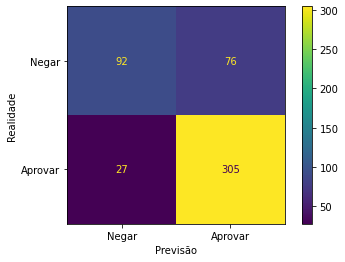

In [44]:
# cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0, 1], display_labels=['Negar', 'Aprovar'])
cmd = plot_confusion_matrix(model, X_test, y_test, display_labels=['Negar', 'Aprovar'])  # scikit-learn=0.23
cmd.ax_.set(xlabel='Previsão', ylabel='Realidade')
plt.show()

## Watson Machine Learning

As etapas da publicação serão colocadas em funções individuais.

Primeiro, será usando um cliente da API do Watson Machine Learning para definir o espaço de publicação padrão:

#### Funções auxiliares

In [45]:
def get_client(API_KEY):
    location = 'us-south'
    wml_credentials = {
        "apikey": API_KEY,
        "url": 'https://' + location + '.ml.cloud.ibm.com'
    }
    return APIClient(wml_credentials)

def set_default_space(client):
    # The DEPLOYMENT_SPACE_GUID was copied from the output of
    # client.spaces.list(limit=10)
    DEPLOYMENT_SPACE_GUID = os.getenv("DEPLOYMENT_SPACE_GUID")
    client.set.default_space(DEPLOYMENT_SPACE_GUID)

O transformador customizado será enviado para o WML:

In [46]:
def store_user_package_extension(client):
    meta_prop_pkg_extn = {
        client.package_extensions.ConfigurationMetaNames.NAME: "Custom_Sklearn_Transformers",
        client.package_extensions.ConfigurationMetaNames.DESCRIPTION: "Extensão para transformações personalizadas",
        client.package_extensions.ConfigurationMetaNames.TYPE: "pip_zip"
    }

    # Subir o pacote
    pkg_extn_details = client.package_extensions.store(meta_props=meta_prop_pkg_extn,
                                                       file_path="custom_sklearn_transformers.zip")

    # Salvar as informações sobre o pacote
    pkg_extn_uid = client.package_extensions.get_uid(pkg_extn_details)
    return pkg_extn_uid

Vamos agora criar uma especificação de software com o nosso pacote customizado, para que o WML possa utilizar.

In [47]:
def store_software_specification(client, pkg_extn_uid):
    base_sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.8")
    
    # Metadados da nova especificação de software
    meta_prop_sw_spec = {
        client.software_specifications.ConfigurationMetaNames.NAME: "sw_spec_custom_sklearn_transformers",
        client.software_specifications.ConfigurationMetaNames.DESCRIPTION: "Especificação de software com transformações personalizadas",
        client.software_specifications.ConfigurationMetaNames.BASE_SOFTWARE_SPECIFICATION: {"guid": base_sw_spec_uid}
    }

    # Criando a nova especificação de software e obtendo seu ID
    sw_spec_details = client.software_specifications.store(meta_props=meta_prop_sw_spec)
    sw_spec_uid = client.software_specifications.get_uid(sw_spec_details)

    # Adicionando o pacote customizado à nova especificação
    client.software_specifications.add_package_extension(sw_spec_uid, pkg_extn_uid)
    return sw_spec_uid

Finalmente, vamos publicar a pipeline utilizando a especificação de software customizada que criamos.

In [48]:
def store_model(client, sw_spec_uid, model):
    # Metadados do modelo
    model_props = {
        client.repository.ModelMetaNames.NAME: "Pipeline customizada",
        client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
        client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid
    }

    # Publicando a Pipeline como um modelo
    # This creates a new Model asset in the deployment space on Watson Machine Learning:
    # https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas
    published_model = client.repository.store_model(model=model, meta_props=model_props)
    published_model_uid = client.repository.get_model_uid(published_model)
    client.repository.get_details(published_model_uid)
    return published_model_uid

Agora que o modelo está salvo, vamos deixá-lo disponível online, para que possamos testá-lo:

In [49]:
def create_deploy(client, published_model_uid):
    # Metadados para publicação do modelo
    metadata = {
        client.deployments.ConfigurationMetaNames.NAME: "Publicação do modelo customizado",
        client.deployments.ConfigurationMetaNames.ONLINE: {}
    }

    # Publicar
    created_deployment = client.deployments.create(published_model_uid, meta_props=metadata)

    # There should be a new Deployment on the space:
    # https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas
    return created_deployment

Adaptando um trecho de código fornecido na referência da API, na página de deployment do modelo, podemos testar a API implementada:

In [50]:
def make_test_request_to_api(client, deployment_id):
    meta_props = {
        "input_data": [
            {
                "fields": [
                    "ID",
                    "CHECKING_BALANCE", "PAYMENT_TERM", "CREDIT_HISTORY", "LOAN_PURPOSE",
                    "LOAN_AMOUNT", "EXISTING_SAVINGS", "EMPLOYMENT_DURATION", "INSTALLMENT_PERCENT",
                    "SEX", "OTHERS_ON_LOAN", "CURRENT_RESIDENCE_DURATION", "PROPERTY",
                    "AGE", "INSTALLMENT_PLANS", "HOUSING", "EXISTING_CREDITS_COUNT",
                    "JOB_TYPE", "DEPENDENTS", "TELEPHONE", "FOREIGN_WORKER",
                ],
                "values": [
                    [
                        1234,
                        None, 987.0, None, "CAR_NEW",
                        4567.0, None, 5.0, 4.0,
                        "M", "NONE", 3.0, "SAVINGS_INSURANCE",
                        42.0, "NONE", "OWN", None,
                        3.0, 1.0, 1.0, 1.0,
                    ],
                    [
                        4321,
                        "NO_CHECKING", 333.0, "PRIOR_PAYMENTS_DELAYED", "BUSINESS",
                        3333.3, 111.1, 13.0, 3.0,
                        "F", "BANK", 2.0, "REAL_ESTATE",
                        33.0, "NONE", "RENT", 1.0,
                        2.0, 2.0, 0.0, 0.0,
                    ],
                ],
            }
        ]
    }
    response_scoring = client.deployments.score(deployment_id, meta_props)

    # See documentation at https://cloud.ibm.com/apidocs/machine-learning?code=python#deployments-compute-predictions
    print("Scoring response")
    display(response_scoring)

#### Publicação do modelo e teste pela API

Quando estiver pronto para publicar o modelo, basta descomentar as linhas da célula abaixo:

In [51]:
# load_dotenv(find_dotenv())
# API_KEY = os.getenv("API_KEY")

# client = get_client(API_KEY)
# set_default_space(client)
# pkg_extn_uid = store_user_package_extension(client)
# sw_spec_uid = store_software_specification(client, pkg_extn_uid)
# published_model_uid = store_model(client, sw_spec_uid, pipe)
# created_deployment = create_deploy(client, published_model_uid)
# deployment_uid = client.deployments.get_uid(created_deployment)
# make_test_request_to_api(client, deployment_uid)

# print("O modelo está publicado! "
#       "Para submeter o desafio, basta acessar https://maratona.dev/challenge/1, "
#       "e utilizar as credenciais abaixo para realizar a submissão:")
# print("Credenciais para envio (não compartilhe esses dados com ninguém!)\n\n"
#       f"API key: {API_KEY}\nDeployment ID: {deployment_uid}")

## Preenchimento do arquivo de respostas

In [52]:
answers['ALLOW'] = model.predict(answers)
display(answers.sample(2, random_state=seed))
answers.to_csv("ANSWERS.csv", index=False)

,ID,CHECKING_BALANCE,PAYMENT_TERM,CREDIT_HISTORY,LOAN_PURPOSE,LOAN_AMOUNT,EXISTING_SAVINGS,EMPLOYMENT_DURATION,INSTALLMENT_PERCENT,SEX,...,PROPERTY,AGE,INSTALLMENT_PLANS,HOUSING,EXISTING_CREDITS_COUNT,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,ALLOW
993,42455,-211.72,155,PRIOR_PAYMENTS_DELAYED,CAR_USED,2528,72.15,2,2,M,...,REAL_ESTATE,23,NONE,RENT,1,3,1,0,1,1
859,243067,NO_CHECKING,660,OUTSTANDING_CREDIT,FURNITURE,2634,UNKNOWN,6,3,F,...,UNKNOWN,43,NONE,OWN,2,3,2,1,1,0


In [53]:
answers['ALLOW'].value_counts(normalize=True).to_frame().T

,1,0
ALLOW,0.766,0.234


In [54]:
!rm -rf código.zip
!zip --exclude '*/.git/*' -rq código.zip custom_sklearn_transformers notebook.ipynb
!ls código.zip

código.zip
